In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import CoraFull, Planetoid, CitationFull
import torch_geometric.nn as gnn 
import torch_geometric.transforms as T
from torchsummary import summary

from adamp import AdamP

#from models import GPS
#from utils import test_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

/home/sujin/anaconda3/envs/ds503/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=3)

In [3]:
transform = T.Compose([T.NormalizeFeatures(), T.AddRandomWalkPE(12, 'RWPE')])
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=transform)

In [3]:
#torch.save(dataset, "/home/sujin/project/DS503/ds503/dataset/Cora/cora/RandomWalkPE.pt")
#dataset = torch.load("/home/sujin/project/DS503/ds503/dataset/Cora/cora/RandomWalkPE.pt")

In [4]:
'''
data = dataset[0]
df = pd.DataFrame(data.x.cpu())
df['y'] = data.y.cpu()
train, valid = train_test_split(df, stratify=df.y, test_size=0.33)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train.index]=True
data = data.to(device)
'''

"\ndata = dataset[0]\ndf = pd.DataFrame(data.x.cpu())\ndf['y'] = data.y.cpu()\ntrain, valid = train_test_split(df, stratify=df.y, test_size=0.33)\ndata.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)\ndata.train_mask[train.index]=True\ndata = data.to(device)\n"

In [5]:
#torch.save(data.cpu(), "/home/sujin/sujin/ds503/dataset/RandomWalkPE.pt")

In [4]:
data = torch.load("/home/sujin/sujin/ds503/dataset/RandomWalkPE.pt")
data = data.to(device)

# GIN backbone

In [7]:
import random
import numpy as np

import torch
import torch.nn as nn

import torch_geometric.nn as gnn 

import torch
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch_geometric.nn.conv import GINConv, GPSConv

class GPS(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, pe_dim, number_of_classes, number_of_nodes, num_layers, heads=8):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.pe_dim = pe_dim
        self.number_of_classes = number_of_classes
        self.number_of_nodes = number_of_nodes
        self.num_layers = num_layers
        self.heads=heads
        
        self.node_emb = Linear(self.in_channels, self.hidden_channels)
        #self.pe_lin = Linear(self.pe_dim, self.hidden_channels)

        self.layers = ModuleList()
        for _ in range(self.num_layers):
            net = Sequential(
                Linear(self.hidden_channels, self.hidden_channels),
                ReLU(),
                Linear(self.hidden_channels, self.hidden_channels),
            )
            
            conv = GPSConv(channels = self.hidden_channels, conv = GINConv(net), heads=self.heads, attn_dropout=0.5)
            self.layers.append(conv)

        self.readout = Linear(self.hidden_channels, self.number_of_classes)

    def forward(self, x, pe, edge_index):
        h = self.node_emb(x) #+ self.pe_lin(pe)
        for layer in self.layers:
            h = layer(h, edge_index)
        h = self.readout(h)

        return h
    


# SAGE backbone

In [8]:
import random
import numpy as np

import torch
import torch.nn as nn

import torch_geometric.nn as gnn 

import torch
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch_geometric.nn.conv import GINConv, GPSConv, SAGEConv

class GPS(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, pe_dim, number_of_classes, number_of_nodes, num_layers, heads=8):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.pe_dim = pe_dim
        self.number_of_classes = number_of_classes
        self.number_of_nodes = number_of_nodes
        self.num_layers = num_layers
        self.heads=heads
        
        self.node_emb = Linear(self.in_channels, self.hidden_channels)
        self.pe_lin = Linear(self.pe_dim, self.hidden_channels)

        self.layers = ModuleList()
        for _ in range(self.num_layers):
            conv = GPSConv(channels = self.hidden_channels, conv = SAGEConv(-1, self.hidden_channels), heads=self.heads, attn_dropout=0.5)
            self.layers.append(conv)

        self.readout = Linear(self.hidden_channels, self.number_of_classes)

    def forward(self, x, pe, edge_index):
        h = self.node_emb(x) + self.pe_lin(pe)
        for layer in self.layers:
            h = layer(h, edge_index)
        h = self.readout(h)

        return h
    

# Train

In [9]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [10]:
model = GPS(in_channels = data.x.shape[1],\
             hidden_channels=256,\
                pe_dim = 12,\
                  number_of_classes = len(data.y.unique()),\
                    number_of_nodes = data.x.shape[0],\
                        num_layers = 4,\
                          heads=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamP(model.parameters(), lr=0.0001, weight_decay=5e-4)

In [11]:
get_n_params(model)

4362822

In [12]:
def train_model(model, data:torch_geometric.data.data.Data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()    
    out = model(data.x, data.RWPE, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=-1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    acc = int(correct.sum()) / int(data.train_mask.sum())
    return loss.detach().cpu().numpy(), acc

In [13]:
losses = []
accs = []
data = data.to(device)
for epoch in range(300):
    loss, acc = train_model(model, data, optimizer, criterion)
    losses.append(loss.item())
    accs.append(100*acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {100*acc:.2f}')

Epoch: 000, Loss: 4.4344, Acc: 1.13
Epoch: 001, Loss: 4.3433, Acc: 1.46
Epoch: 002, Loss: 4.2725, Acc: 2.96
Epoch: 003, Loss: 4.2156, Acc: 4.01
Epoch: 004, Loss: 4.1704, Acc: 4.90
Epoch: 005, Loss: 4.1339, Acc: 6.27
Epoch: 006, Loss: 4.1035, Acc: 6.75
Epoch: 007, Loss: 4.0766, Acc: 7.02
Epoch: 008, Loss: 4.0532, Acc: 7.20
Epoch: 009, Loss: 4.0312, Acc: 7.35
Epoch: 010, Loss: 4.0112, Acc: 7.51
Epoch: 011, Loss: 3.9911, Acc: 7.93
Epoch: 012, Loss: 3.9717, Acc: 8.36
Epoch: 013, Loss: 3.9514, Acc: 8.72
Epoch: 014, Loss: 3.9309, Acc: 8.96
Epoch: 015, Loss: 3.9089, Acc: 9.28
Epoch: 016, Loss: 3.8863, Acc: 9.61
Epoch: 017, Loss: 3.8613, Acc: 10.00
Epoch: 018, Loss: 3.8347, Acc: 10.34
Epoch: 019, Loss: 3.8060, Acc: 10.99
Epoch: 020, Loss: 3.7786, Acc: 11.67
Epoch: 021, Loss: 3.7496, Acc: 12.28
Epoch: 022, Loss: 3.7174, Acc: 13.05
Epoch: 023, Loss: 3.6811, Acc: 14.42
Epoch: 024, Loss: 3.6436, Acc: 15.62
Epoch: 025, Loss: 3.6048, Acc: 17.07
Epoch: 026, Loss: 3.5606, Acc: 18.18
Epoch: 027, Loss: 

KeyboardInterrupt: 

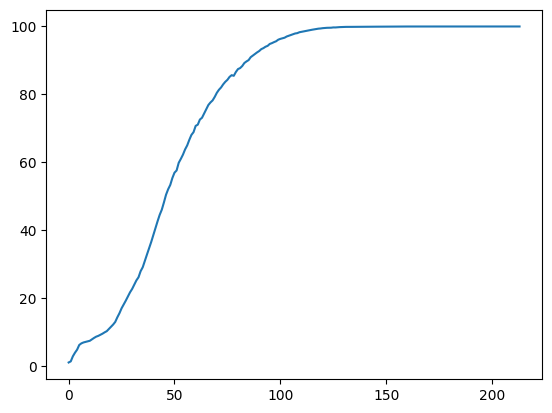

In [14]:
plt.plot(accs)

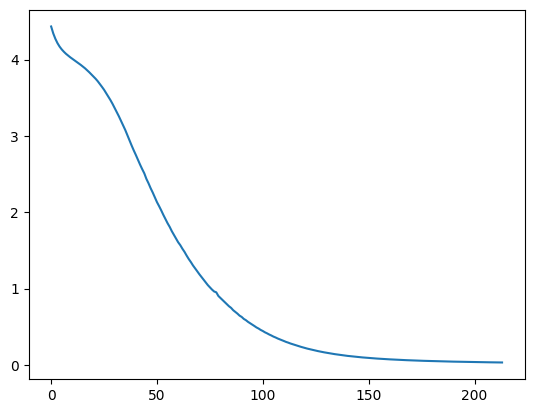

In [15]:
plt.plot(losses)

In [16]:
model.eval()
out = model(data.x, data.RWPE, data.edge_index)
pred = out.argmax(dim=-1)
report = pd.DataFrame(classification_report(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), output_dict=True)).T

In [17]:
result_sliced = report.iloc[:-3 if len(report) < 23 else 20, :]
acc = report.loc['accuracy'][0]
report.loc['minorities-f1',:] = result_sliced.mean(axis=0)
print(f'Test Acc: {100*acc}')

Test Acc: 62.41579914268218


In [23]:
report

,precision,recall,f1-score,support
0,0.803279,0.576471,0.671233,85.000000
1,0.636364,0.411765,0.500000,17.000000
2,0.587629,0.712500,0.644068,80.000000
3,0.839080,0.584000,0.688679,125.000000
4,0.545455,0.857143,0.666667,21.000000
...,...,...,...,...
69,0.700000,0.700000,0.700000,10.000000
accuracy,0.624158,0.624158,0.624158,0.624158
macro avg,0.611234,0.568290,0.573512,6532.000000
weighted avg,0.652875,0.624158,0.623947,6532.000000


In [24]:
#GraphSAGE_layers4_neurons256
report.to_csv("/home/sujin/sujin/ds503/results/GPS_layers4_neurons256_SAGE_RWPE.csv")

In [25]:
train_res_loss = pd.DataFrame({'GPS_layers4_neurons256_SAGE_RWPE' : losses})
train_res_loss.to_csv('./results/train_results/GPS_layers4_neurons256_SAGE_RWPE_loss.csv', index=False)

In [26]:
train_res_acc = pd.DataFrame({'GPS_layers4_neurons256_RWPE' : accs})
train_res_acc.to_csv('./results/train_results/GPS_layers4_neurons256_SAGE_RWPE_acc.csv', index=False)